In [1]:
%run utils.ipynb
import spacy
from spacy import displacy
import nltk
import torch
from supar import Parser
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering,AffinityPropagation,KMeans
import seaborn as sbs
import xgboost as xgb
from sklearn.metrics import explained_variance_score,mean_squared_error
from thinc.api import set_gpu_allocator, require_gpu
import seaborn as sbs
import numpy as np
from sklearn.linear_model import LinearRegression
set_gpu_allocator("pytorch")
require_gpu(0)

True

In [366]:
loader = DataLoader()
d = loader.GetData('final')

In [234]:
d.head()

,用户ID,学号,姓名,班级,院系,任课教师,Class,Prompt,score,text
0,1003246377,21120199,古丽依娜·买买提克力木,2021-22冬季通用英语C2刘学青1005期末,法学院,1002658406(刘学青),C,19121438,9.0,...
1,1003248323,21122145,王名振,2021-22冬季通用英语B2谢怡沁1014期末,通信与信息工程学院,1002658415(谢怡沁),B,19121435,9.6,"As a person, the people around us are always c..."
2,1003249593,21123420,周祺,2021-22冬季通用英语C2刘学青1016期末,上海美术学院,1002658406(刘学青),C,19121440,8.7,"Since we are little, we have been told to read..."
3,1003250643,21124470,张芷昕,2021-22冬季通用学术英语A2张新玲1008期末,音乐学院,1002658431(张新玲),A,1000561535,11.1,"With the development of networks, Internet i..."
4,1003246209,21120031,晏三,2021-22冬季通用英语B2谢怡沁1014期末,法学院,1002658415(谢怡沁),B,19121437,10.5,"As we all know, friendship is essential for th..."


In [367]:
d.loc[:,'level'] = 0
d.loc[d['score'] >= 11,'level'] = '25%'
d.loc[(d['score'] < 11) & (d['score'] >= 10.3),'level'] = '50%'
d.loc[(d['score'] < 10.3) & (d['score'] >= 9.6),'level'] = '75%'
d.loc[d['score'] < 9.6,'level'] = '100%'
d = d.loc[d['score'] != 0]
#d = d[d['Class'] == 'B']
#d = d[d['任课教师'].isin(['1002658413(白静远)','1002658414(薛清)','1002658415(谢怡沁)'])]
len(d)

3784

In [368]:
#d = d[d['Class'] == 'B']
d = d[d['level'] == '25%']

In [4]:
NLP = spacy.load('en_core_web_trf')

In [28]:
doc_sent = []
with open('features/final-winter-sim.txt','r',encoding='utf-8') as f:
    for line in f.readlines():
        doc_sent.append(line.strip('\n'))

In [237]:
count = dict()
doc_sent = []
for i in d.index:
    doc = NLP(d['text'][i])
    dep_sent = ''
    for s in doc.sents:
        for t in s:
            if t.pos_ == 'VERB':
                left = [m.dep_ for m in t.lefts if m.text.isalpha()]
                right = [m.dep_ for m in t.rights if m.text.isalpha()]
                vac = '_'.join(left) + '_V_' + '_'.join(right)
                dep_sent += vac
                dep_sent += ', '
    doc_sent.append(dep_sent)

In [238]:
with open('features/final-winter-sim.txt','w',encoding='utf-8') as f:
    for line in doc_sent:
        f.write(line)
        f.write('\n')

In [76]:
count = dict()
essay_in_sent = []
for i in d.index:
    doc = NLP(d['text'][i])
    dep_sent = ''
    for s in doc.sents:
        for t in s:
            dep_sent += t.dep_
            dep_sent += ', '
    essay_in_sent.append(dep_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors


In [77]:
cttr = []
for i in range(len(essay_in_sent)):
    txt = essay_in_sent[i].split(', ')
    count = 1
    sttr = 0
    if len(txt) < 50:
        typec = len(set(txt[:len(txt)]))
        ttr = typec/len(txt)
        sttr += ttr
        cttr.append(sttr)
        continue
    for num in range(len(txt) // 50):
        typec = len(set(txt[num*50:(num+1)*50]))
        ttr = typec/50
        sttr += ttr
        count += 1
    typec = len(set(txt[len(txt) // 50 * 50:len(txt)]))
    ttr = typec/(len(txt) -( len(txt) // 50 * 50)+ 1)
    sttr += ttr
    cttr.append(sttr/(count + 1))

In [78]:
TrainX,TestX = np.array(cttr[:2500]).reshape(2500,1),np.array(cttr[2500:]).reshape(1284,1)

In [262]:
TrainX,TestX = features[:1000],features[1000:]

In [263]:
TrainY,TestY = d.loc[d.index[:1000],'score'],d.loc[d.index[1000:],'score']

In [264]:
model = LinearRegression() 
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)

In [265]:
explained_variance_score(TestY,PredY)

0.021565996618451932

In [266]:
from sklearn.metrics import mean_squared_error
mean_squared_error(TestY,PredY,squared = False)

0.8700311246313917

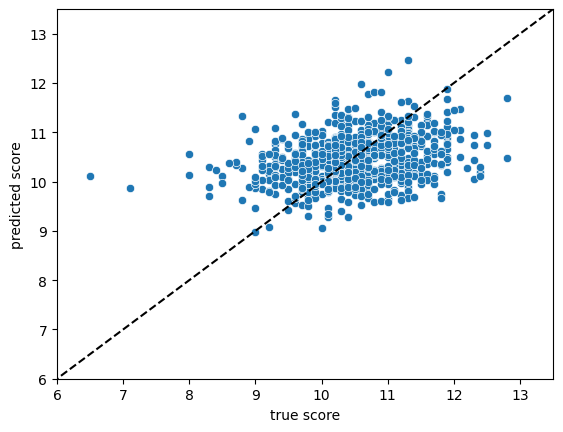

In [267]:
g = sbs.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((6,13.5))
g.set_xlim((6,13.5))
g = sbs.lineplot(x=[0,13.5],y=[0,13.5],color='black')
g.lines[0].set_linestyle("--")

In [369]:
vector = TfidfVectorizer(max_features=1000)
features = vector.fit_transform([doc_sent[d.index[i]] for i in range(len(d.index))])

In [370]:
features

<971x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 21472 stored elements in Compressed Sparse Row format>

In [371]:
svd = TruncatedSVD(150)
features = svd.fit_transform(features)

In [386]:
#features = features.toarray()
sim = cosine_similarity(features)

In [372]:
colors= dict()
count = 0
for i in list(d['Prompt']):
    if not i in colors:
        colors[i] = sbs.color_palette('hls',15)[count]
        count += 1

In [373]:
class_num = [colors[d['Prompt'][i]] for i in d.index]

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


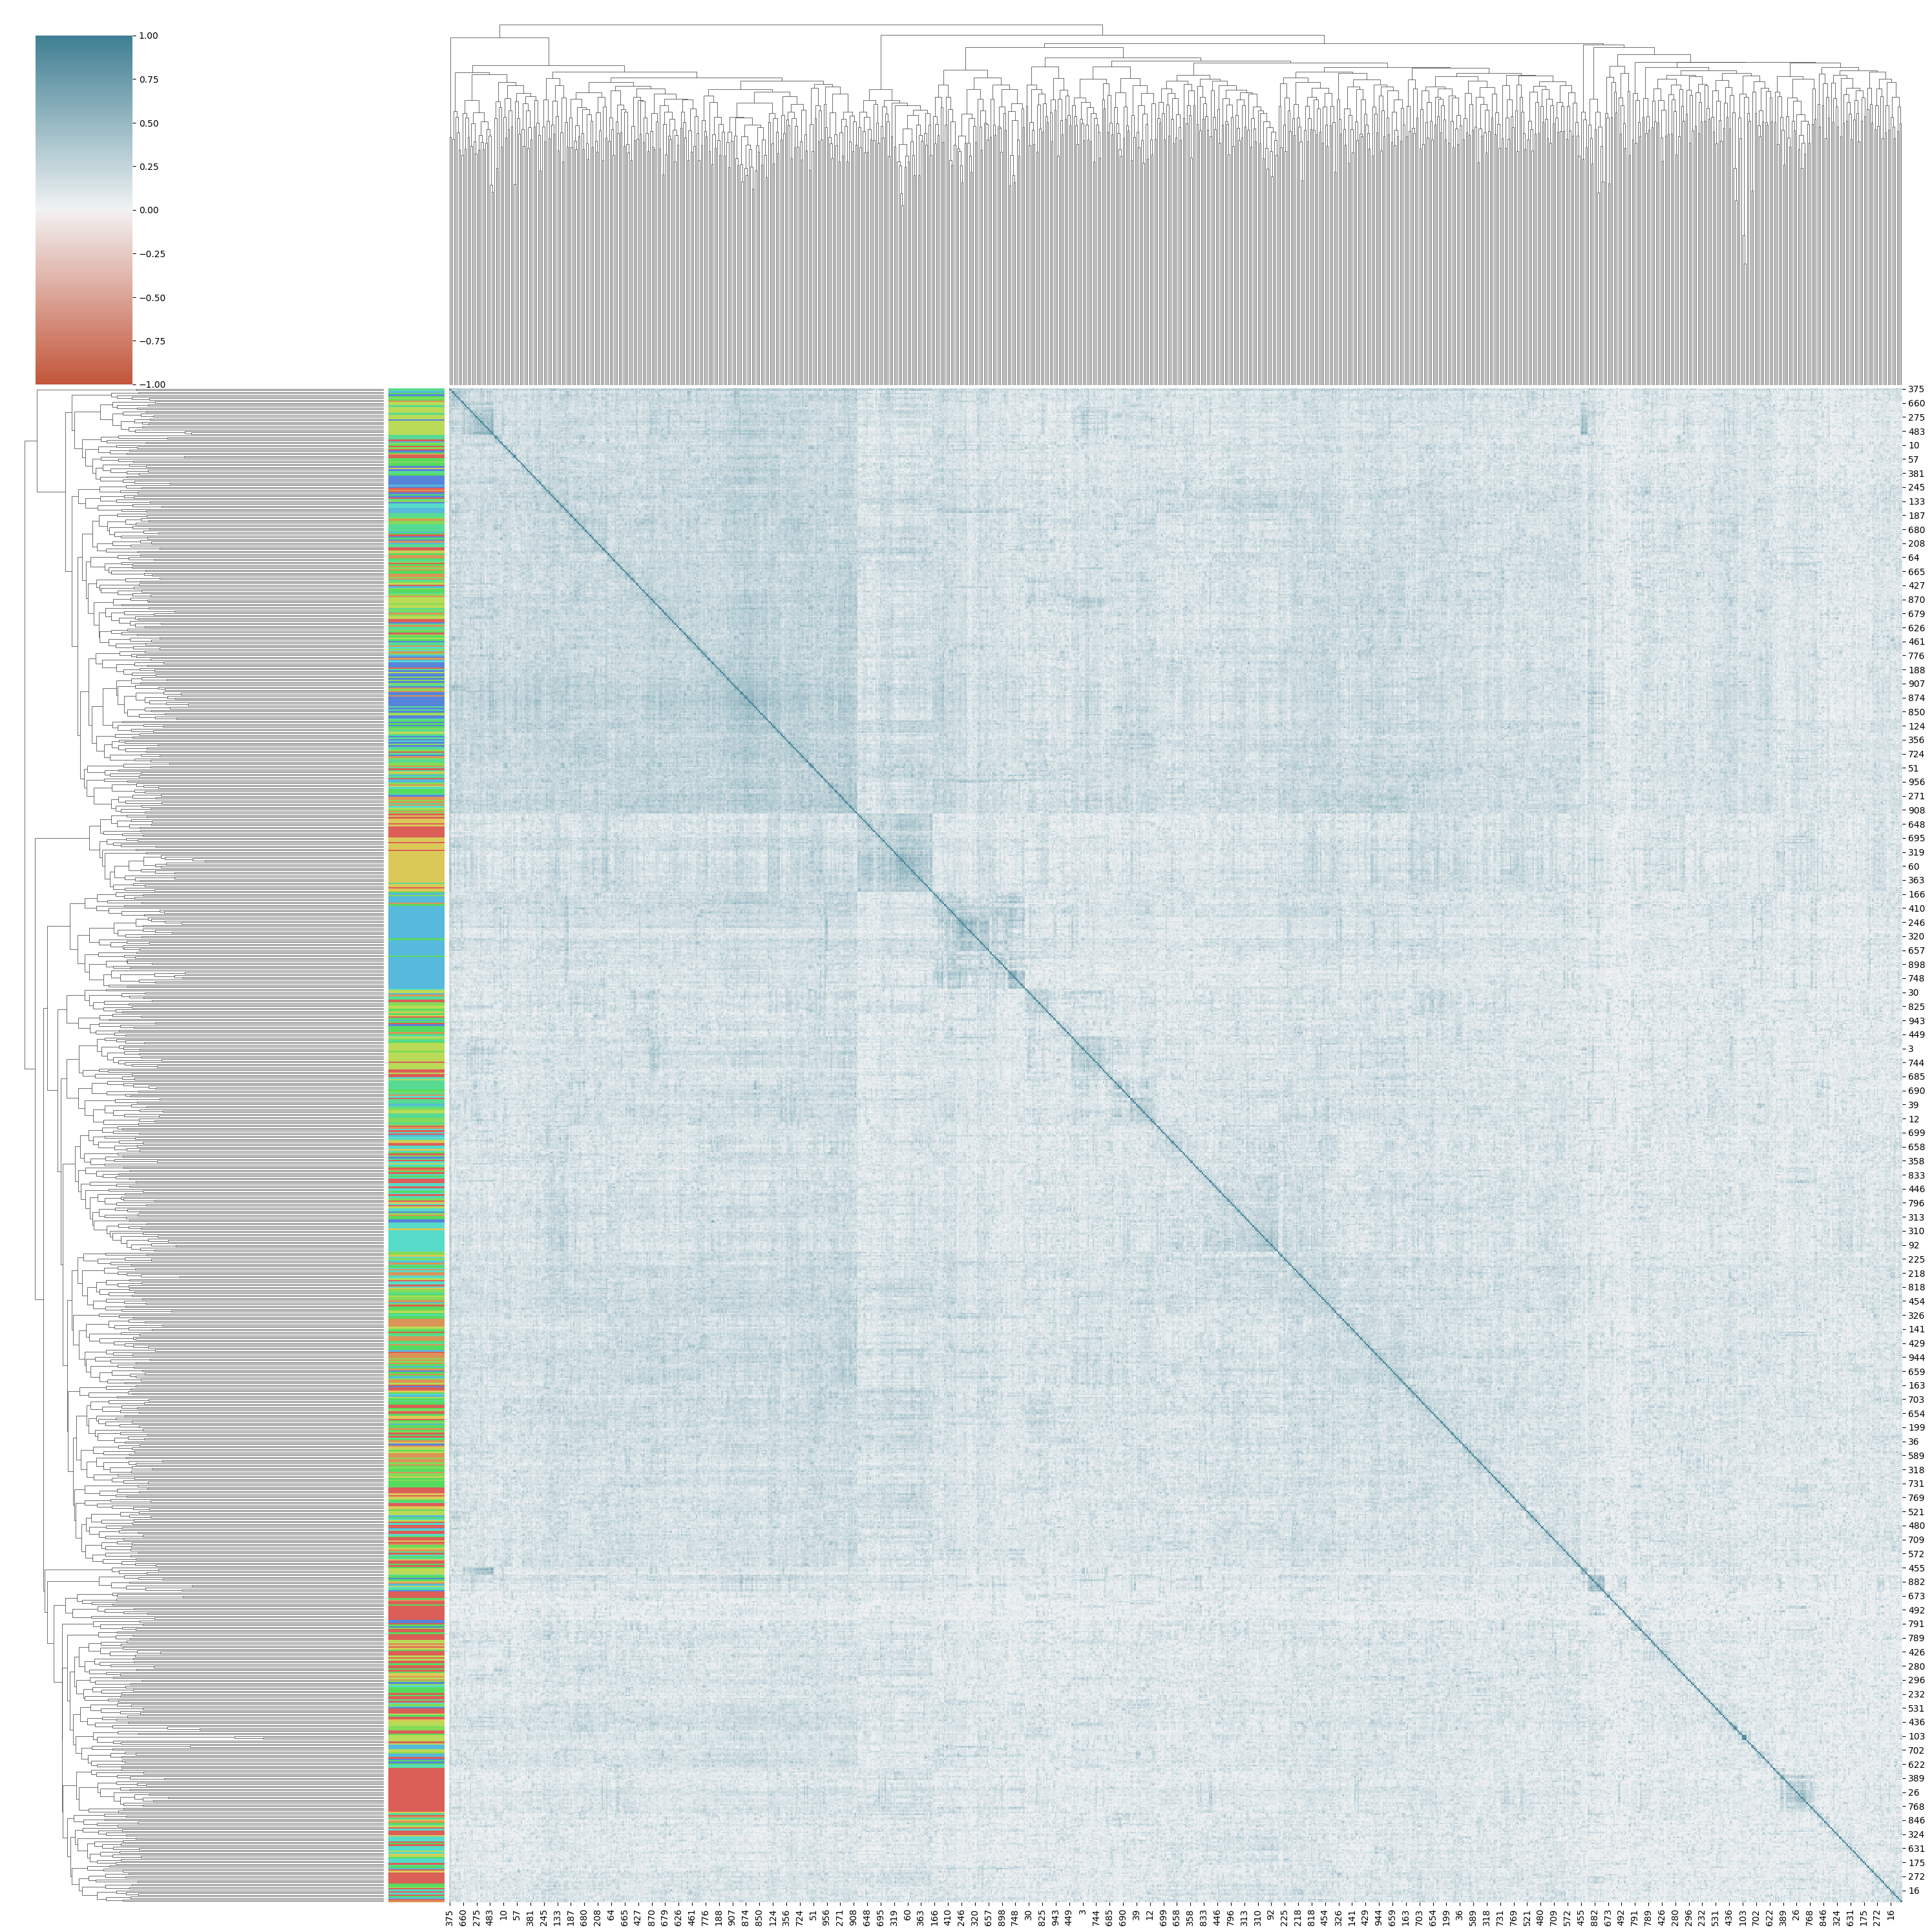

In [388]:
sbs.clustermap(sim,figsize = (30,30),vmin=-1,vmax=1,center=0,cmap=cmap,row_colors=class_num,col_cluster=True)

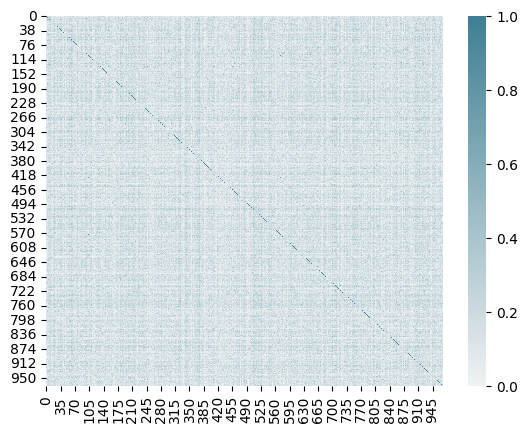

In [387]:
cmap = sbs.diverging_palette(20, 220, as_cmap=True)
g = sbs.heatmap(sim,vmin=0,vmax=1,center=0,cmap=cmap)

In [381]:
cluster_model = KMeans(10)
l = cluster_model.fit_predict(features)

In [384]:
l = list(d['Prompt'])
c = dict()
for i in range(len(l)):
    if l[i] in c:
        c[l[i]].append(i)
    else:
        c[l[i]] = [i]
c = [tuple(c[i]) for i in c]

In [382]:
c = dict()
for i in range(len(l)):
    if l[i] in c:
        c[l[i]].append(i)
    else:
        c[l[i]] = [i]
c = [tuple(c[i]) for i in c]

In [376]:
vis = TSNE()
pos = vis.fit_transform(features)

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [326]:
pos = features

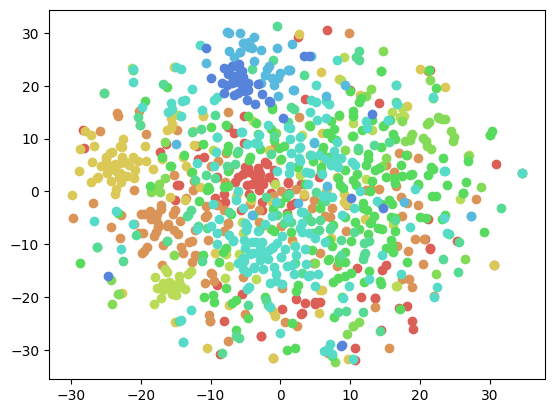

In [383]:
import matplotlib.pyplot as plt
def norm(n):
    if n >= 0:
        return np.sqrt(n)*2
    else:
        return -np.sqrt(-n)*2
count = 0 
for clu in c:
    x = []
    y = []
    for i in clu:
        x.append(pos[i, 0])
        y.append(pos[i,1])
    plt.scatter(x,y,color = sbs.color_palette('hls',15)[count])
    count += 1

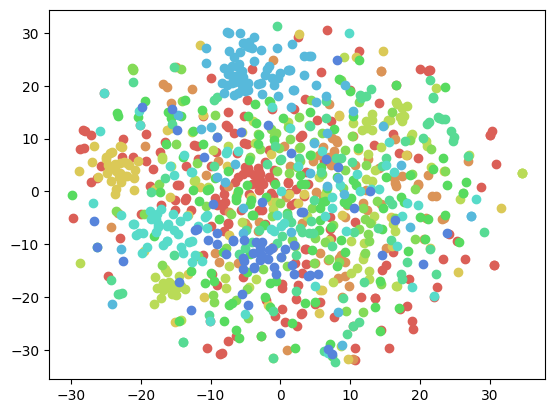

In [385]:
import matplotlib.pyplot as plt
count = 0
for clu in c:
    x = []
    y = []
    for i in clu:
        x.append(pos[i, 0])
        y.append(pos[i,1])
    plt.scatter(x,y,color = sbs.color_palette('hls',15)[count])
    count += 1